In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

# Self-RAG

Self-RAG is a recent paper that introduces an interesting approach for active RAG. 

The framework trains a single arbitrary LM (LLaMA2-7b, 13b) to generate tokens that govern the RAG process:

1. Should I retrieve from retriever, `R` -

* Token: `Retrieve`
* Input: `x (question)` OR `x (question)`, `y (generation)`
* Decides when to retrieve `D` chunks with `R`
* Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -

* Token: `ISREL`
* * Input: (`x (question)`, `d (chunk)`) for `d` in `D`
* `d` provides useful information to solve `x`
* Output: `relevant, irrelevant`


3. Are the LLM generation from each chunk in `D` is relevant to the chunk (hallucinations, etc)  -

* Token: `ISSUP`
* Input: `x (question)`, `d (chunk)`,  `y (generation)` for `d` in `D`
* All of the verification-worthy statements in `y (generation)` are supported by `d`
* Output: `{fully supported, partially supported, no support`

4. The LLM generation from each chunk in `D` is a useful response to `x (question)` -

* Token: `ISUSE`
* Input: `x (question)`, `y (generation)` for `d` in `D`
* `y (generation)` is a useful response to `x (question)`.
* Output: `{5, 4, 3, 2, 1}`

We can represent this as a graph:

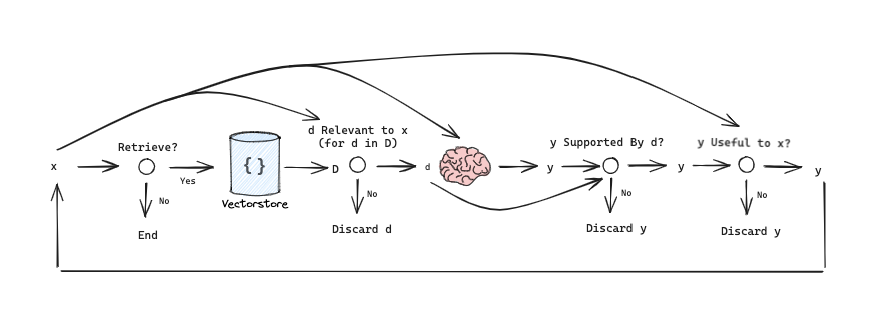

Paper -

https://arxiv.org/abs/2310.11511

---

Let's implement this from scratch using [LangGraph](https://python.langchain.com/docs/langgraph).

## Retriever
 
Let's index 3 blog posts.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

## State
 
We will define a graph.

Our state will be a `dict`.

We can access this from any graph node as `state['keys']`.

In [ ]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of an agent in the conversation.

    Attributes:
        keys: A dictionary where each key is a string and the value is expected to be a list or another structure
              that supports addition with `operator.add`. This could be used, for instance, to accumulate messages
              or other pieces of data throughout the graph.
    """

    keys: Dict[str, any]

## Nodes and Edges

Each `node` will simply modify the `state`.

Each `edge` will choose which `node` to call next.

We can lay out `self-RAG` as a graph:

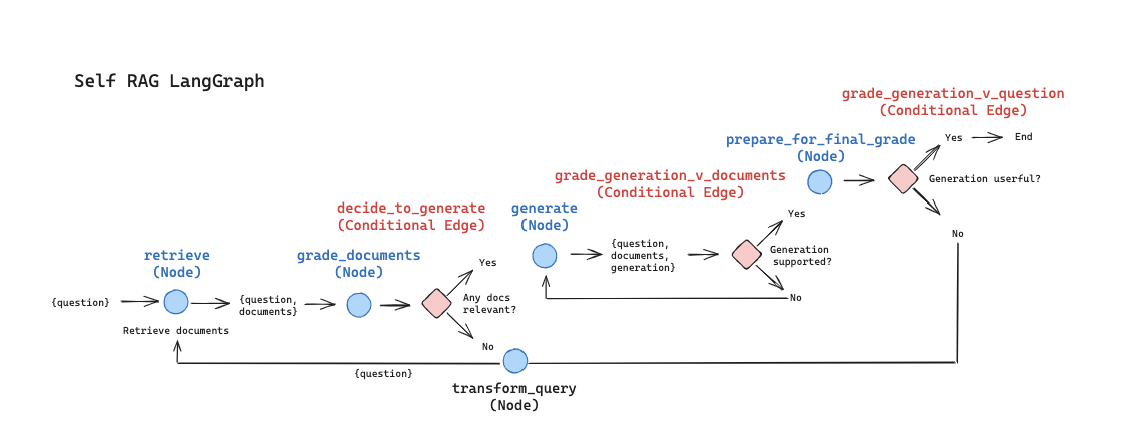

In [ ]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import ToolInvocation

### Nodes ###


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, documents, that contains documents.
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.get_relevant_documents(question)
    return {"keys": {"documents": documents, "question": question}}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, generation, that contains generation.
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, filtered_documents, that contains relevant documents.
    """

    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool | parser_tool

    # Score
    filtered_docs = []
    for d in documents:
        score = chain.invoke({"question": question, "context": d.page_content})
        grade = score[0].binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    return {"keys": {"documents": filtered_docs, "question": question}}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New value saved to question.
    """

    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question: """,
        input_variables=["question"],
    )

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Prompt
    chain = prompt | model | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {"keys": {"documents": documents, "question": better_question}}


def prepare_for_final_grade(state):
    """
    Stage for final grade, passthrough state.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        state (dict): The current state of the agent, including all keys.
    """

    print("---FINAL GRADE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


### Edges ###


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, filtered_documents, that contains relevant documents.
    """

    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents(state):
    """
    Determines whether the generation is grounded in the document.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision score.
    """

    print("---GRADE GENERATION vs DOCUMENTS---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Supported score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
        Here are the facts:
        \n ------- \n
        {documents} 
        \n ------- \n
        Here is the answer: {generation}
        Give a binary score 'yes' or 'no' to indicate whether the answer is grounded in / supported by a set of facts.""",
        input_variables=["generation", "documents"],
    )

    # Chain
    chain = prompt | llm_with_tool | parser_tool

    score = chain.invoke({"generation": generation, "documents": documents})
    grade = score[0].binary_score

    if grade == "yes":
        print("---DECISION: SUPPORTED, MOVE TO FINAL GRADE---")
        return "supported"
    else:
        print("---DECISION: NOT SUPPORTED, GENERATE AGAIN---")
        return "not supported"


def grade_generation_v_question(state):
    """
    Determines whether the generation addresses the question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision score.
    """

    print("---GRADE GENERATION vs QUESTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Useful score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
        Here is the answer:
        \n ------- \n
        {generation} 
        \n ------- \n
        Here is the question: {question}
        Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question.""",
        input_variables=["generation", "question"],
    )

    # Prompt
    chain = prompt | llm_with_tool | parser_tool

    score = chain.invoke({"generation": generation, "question": question})
    grade = score[0].binary_score

    if grade == "yes":
        print("---DECISION: USEFUL---")
        return "useful"
    else:
        print("---DECISION: NOT USEFUL---")
        return "not useful"

## Graph

In [ ]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("prepare_for_final_grade", prepare_for_final_grade)  # passthrough

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents,
    {
        "supported": "prepare_for_final_grade",
        "not supported": "generate",
    },
)
workflow.add_conditional_edges(
    "prepare_for_final_grade",
    grade_generation_v_question,
    {
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [ ]:
# Run
inputs = {"keys": {"question": "Explain how the different types of agent memory work?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

In [ ]:
inputs = {"keys": {"question": "Explain how chain of thought prompting works?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

Trace - 
 
* https://smith.langchain.com/public/55d6180f-aab8-42bc-8799-dadce6247d9b/r
* https://smith.langchain.com/public/f85ebc95-81d9-47fc-91c6-b54e5b78f359/r